# Blackbox with parameters


## Default parameters
One might wonder how to instantiate a VHDL module from MyHDL that takes generics (parameters),
such as the following example:

```
	component FifoBuffer is
		generic (
			ADDR_W          : natural := 6;
			DATA_W          : natural := 16;
			EXTRA_REGISTER  : boolean := false;
			SYN_RAMTYPE     : string  := "block_ram"
		);
		port (
			-- Write enable
			wren      : in  std_logic;
			idata     : in  unsigned(DATA_W-1 downto 0);
			iready    : out std_logic;
			-- Data stream output:
			odata     : out unsigned(DATA_W-1 downto 0);
			oready    : out std_logic;
			rden      : in  std_logic;
			err       : out std_logic;
			-- debug     : out unsigned(16-1 downto 0);
			reset     : in  std_logic;
			clk       : in  std_logic
		);
	end component FifoBuffer;
```

Configure synthesis (local paths):

In [1]:
import config

You might be tempted to write a construct like this:

In [2]:
from myhdl import *
from synthesis.yosys.autowrap import autowrap

DEFAULT_FIFOBUF_PARAM = {
    'ADDR_W' : 6, 'DATA_W' : 16, 'EXTRA_REGISTER' : False, 'SYN_RAMTYPE' : "block_ram"
}

@autowrap
def fifobuffer_attempt(wren, idata, iready, odata, oready, rden, err, reset, clk, \
    **DEFAULT_FIFOBUF_PARAM):
    
    @always(clk.posedge)
    def assign():
        iready.next = False
        odata.next = 0xff
        oready.next = False
        err.next = False
        
    return instances()


However, this is currently not supported. Use this notation:

In [3]:
from myhdl import *
from synthesis.yosys.autowrap import autowrap

@autowrap
def fifobuffer(wren, idata, iready, odata, oready, rden, err, reset, clk, \
    ADDR_W = 6, DATA_W = 16, EXTRA_REGISTER = False, SYN_RAMTYPE = 'block_ram'):
    
    @always(clk.posedge)
    def assign():
        iready.next = False
        odata.next = 0xff
        oready.next = False
        err.next = False
        
    return instances()


### Conversion to RTL

When creating an instance of the black box, you pass the signals and parameters as
arguments as shown below. In this case, an instance of the black box is generated with
`ADDR_W` and `DATA_W` set.

In [4]:
from myhdl.conversion import yshelper

def convert():
    rxfifo_data, rxd  = [Signal(intbv()[8:]) for i in range(2)]
    strobe_rx  = Signal(bool())
    rxovr  = Signal(bool())
    clk  = Signal(bool())
    iready  = Signal(bool())
    reset  = Signal(bool())

    rxfifo_rden, txfifo_wren, rxdata_ready, txfifo_dready, txfifo_strobe = \
        [Signal(bool()) for i in range(5)]
    
    f = fifobuffer(strobe_rx, rxd, iready, rxfifo_data, rxdata_ready, \
                             rxfifo_rden, rxovr, reset, clk, ADDR_W = 7, DATA_W = 8)
    
    design = yshelper.Design("fifobuffer_wrapper")
    f.convert("yosys_module", design)
    return design

design = convert()
design.write_ilang("fifobuffer")

	Infer blackbox: 'fifobuffer'
Adding module with name: fifobuffer_1_8_1_8_1_1_1_1_1
config param ADDR_W = 7
config param DATA_W = 8
Adding module with name: fifobuffer
DEFAULT PARAM ADDR_W = 6
DEFAULT PARAM DATA_W = 16
DEFAULT PARAM EXTRA_REGISTER = False
DEFAULT PARAM SYN_RAMTYPE = block_ram


## RTL View

Note the parameters aren't visible in the RTL schematic.

Generating RTL image...
Display...


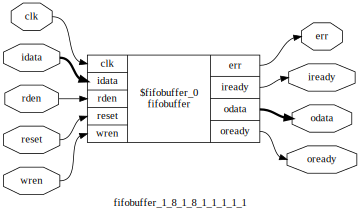

In [5]:
from ys_aux import *
display(to_svg(design, "", 50))

Let's look at the created RTLIL file. The parameter defaults are not stored in the blackbox -- it's a full blackbox.
The default parameters are finally up to the implementation (Verilog/VHDL, ...)

In [6]:
! cat fifobuffer_mapped.il

# Generated by Yosys 0.9+2406 (git sha1 b822beb1, gcc 8.3.0-6 -Og -fPIC)
autoidx 1
attribute \blackbox 1
module \fifobuffer
  parameter \ADDR_W
  parameter \DATA_W
  parameter \EXTRA_REGISTER
  parameter \SYN_RAMTYPE
  wire input 9 \clk
  wire output 7 \err
  wire width 8 input 2 \idata
  wire output 3 \iready
  wire width 8 output 4 \odata
  wire output 5 \oready
  wire input 6 \rden
  wire input 8 \reset
  wire input 1 \wren
end
attribute \top 1
module \fifobuffer_1_8_1_8_1_1_1_1_1
  wire input 9 \clk
  wire output 7 \err
  wire width 8 input 2 \idata
  wire output 3 \iready
  wire width 8 output 4 \odata
  wire output 5 \oready
  wire input 6 \rden
  wire input 8 \reset
  wire input 1 \wren
  cell \fifobuffer $fifobuffer_0
    parameter \ADDR_W 7
    parameter \DATA_W 8
    connect \clk \clk
    connect \err \err
    connect \idata \idata
    connect \iready \iready
    connect \odata \odata
    connect \oready \oready
    connect \rden \rden
    connect \reset \reset
    connect \w